In [31]:
import kachaka_base as base
import pickle
import time
import importlib
importlib.reload(base)

<module 'kachaka_base' from '/home/njz/Documents/kachaka_in_ymzk_lab/kachaka_base.py'>

In [32]:
from kachaka_base import BoxColor


class VirtualKachaka(base.KachakaBase):
    def __init__(self, data_num):
        self.path = "data/sensor_data" + data_num + "/"
        self.update_sensor_data()
        
        ratio = 1000
        with open(self.path + "position.pkl", "rb") as file:
            position = pickle.load(file)

        self.pose = base.Pose(
            position["x"] * ratio, position["y"] * ratio, position["theta"]
        )

        with open(self.path + "theta.pkl", "rb") as file:
            theta = pickle.load(file)

        with open(self.path + "dist.pkl", "rb") as file:
            dist = pickle.load(file)

        self.lidar_data = base.LidarData(dist, theta, self.pose)

    def move_to_pose(self, distination: base.Pose):
        time.sleep(0.3)
        self.pose = distination

    def update_sensor_data(self):
        pass

    def recognize_box_color(self) -> BoxColor:
        # 仮実装　赤のみ
        return BoxColor.RED

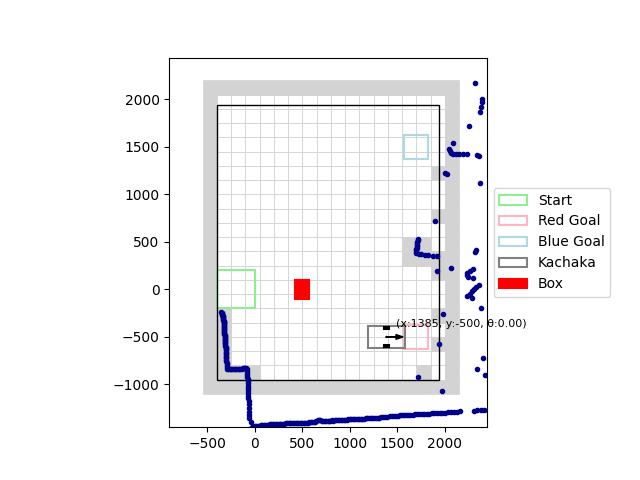

タスクが完了しました


SystemExit: 正常終了

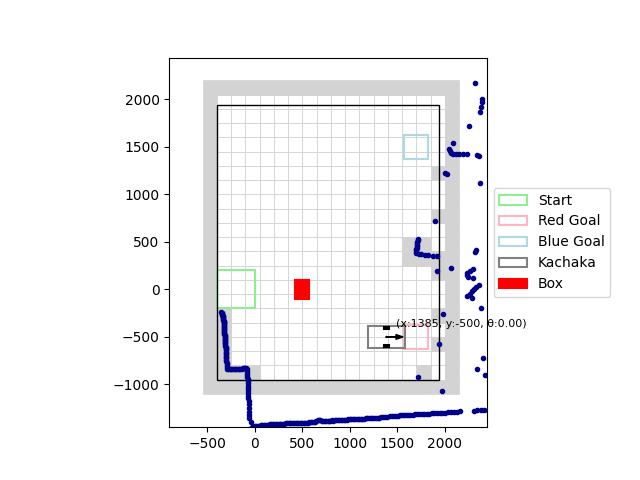

In [33]:
# %matplotlib
%matplotlib ipympl
# %matplotlib inline
# %matplotlib qt
# %matplotlib notebook
# %matplotlib widget

# 初期化 -------------------------------------------------------------
initial_box_pose = base.Pose(500, 0, 0)
red_box_goal = base.Pose(1700, -500, 0)
blue_box_goal = base.Pose(1700, 1500, 0)

box = base.Box(initial_box_pose)
kachaka = VirtualKachaka("5")
map = base.GridMap(
    base.Size(2340, 2890),
    grid_size=base.Size(150, 150),
    origin_offset=base.Pose(400, 950, 0),
    start=base.Pose(-200, 0, 0),
    initial_box_pose=initial_box_pose,
    red_box_goal=red_box_goal,
    blue_box_goal=blue_box_goal,
)
logger = base.TextLogger()
trajectory_planner = base.StraightTrajectoryPlanner()
controller = base.Controller(kachaka, box, map, trajectory_planner, logger)

(x_lim, y_lim) = map.get_axes_lim()
margin = 500 # 表示マージン確保
x_lim = (x_lim[0] - margin, x_lim[1] + margin)
y_lim = (y_lim[0] - margin, y_lim[1] + margin)
plotter = base.Plotter(x_lim, y_lim)

kachaka.pose = base.Pose(0,0,0)

# メインループ ---------------------------------------------------------
while True:
    plotter.update(map, box, kachaka, controller.trajectory)
    controller.update()
    # time.sleep(1.0)

In [ ]:
# GIFアニメーション作成 
plotter.make_gif()
plotter.make_zip_package()

In [ ]:
import shutil


def zip_directory(directory_path, zip_filename):
    try:
        shutil.make_archive(zip_filename, "zip", directory_path)
        print(f"Successfully created {zip_filename}")
    except Exception as e:
        print(f"Error creating {zip_filename}: {e}")

zip_directory("plotter_output", "plotter_output")

Successfully created plotter_output
